In [46]:
#SECTION 1: Importing all the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import linear_model, decomposition
from scipy import stats
import statsmodels.api as sm

In [47]:
#SECTION 1:Importing and cleaning the VCF file
vcf_file = "genotypes.vcf"

# Step 1: find the header line
with open(vcf_file, "r") as f:
    for line in f:
        if line.startswith("#CHROM"):
            header = line.strip().lstrip("#").split("\t")
            break

# Step 2: load the data using that header
vcf_df = pd.read_csv(
    vcf_file,
    sep="\t",
    comment="#",   # ignore metadata lines starting with ##
    header=None,
    names=header,
    low_memory=False
)

vcf_df.head()

# Non-sample columns
fixed_cols = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT"]

# Sample columns (all individuals)
sample_cols = [col for col in vcf_df.columns if col not in fixed_cols]

# Remove everything except the first item before ':'
for col in sample_cols:
    vcf_df[col] = vcf_df[col].astype(str).str.split(":").str[0]

vcf_df.head()

vcf_df.to_csv("cleaned_genotypes.tsv", sep="\t", index=False)


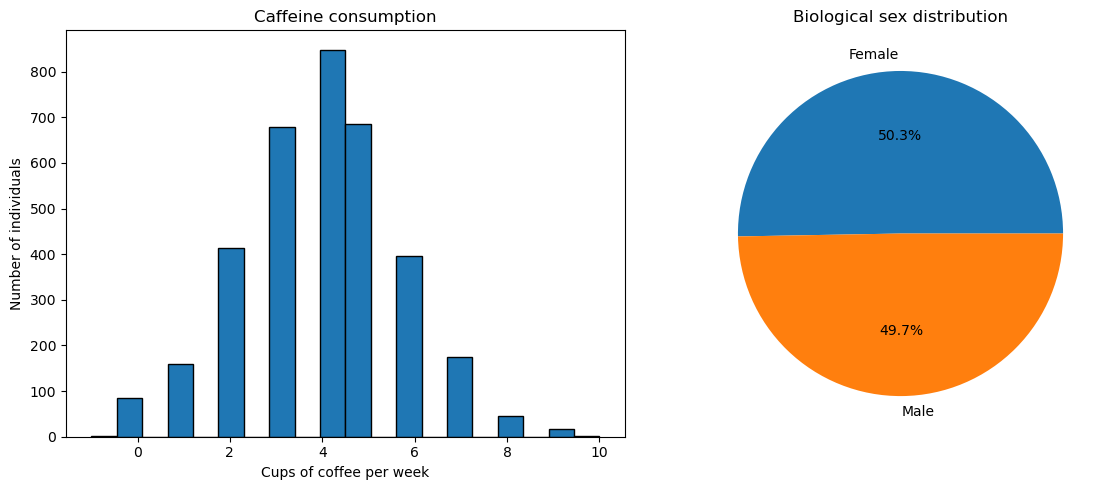

In [48]:
#SECTION 1: Exploratory Data (plots of all annotation data)
annotations = pd.read_csv("annotations.txt", sep="\t")
annotations.head()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: Histogram of caffeine consumption ---
axes[0].hist(annotations["CaffeineConsumption"], bins=20, edgecolor="black")
axes[0].set_xlabel("Cups of coffee per week")
axes[0].set_ylabel("Number of individuals")
axes[0].set_title("Caffeine consumption")

# Right: pie chart with Male/Female labels
sex_counts = annotations["isFemale"].value_counts()

axes[1].pie(
    sex_counts,
    labels=[("Female" if str(x).lower() == "true" else "Male") for x in sex_counts.index],
    autopct="%1.1f%%"
)
axes[1].set_title("Biological sex distribution")

plt.tight_layout()
plt.show()

C:\Users\leams\AppData\Local\Temp\ipykernel_32804\141002830.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vcf_df["call_rate"] = call_rate


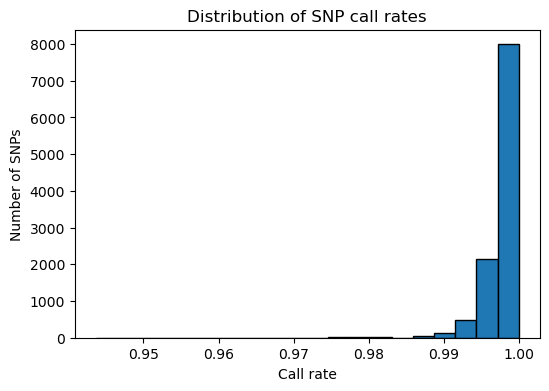

2888

In [49]:
#SECTION 2: Call Rates

#Identify sample genotype columns
fixed_cols = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT"]
sample_cols = [col for col in vcf_df.columns if col not in fixed_cols]

# Compute call rate
is_called = (vcf_df[sample_cols] != "./.")
call_rate = is_called.sum(axis=1) / len(sample_cols)
vcf_df["call_rate"] = call_rate

# Histogram
plt.figure(figsize=(6,4))
plt.hist(call_rate, bins=20, edgecolor="black")
plt.xlabel("Call rate")
plt.ylabel("Number of SNPs")
plt.title("Distribution of SNP call rates")
plt.show()

# Filter variants with call rate = 1.0
vcf_filtered = vcf_df[vcf_df["call_rate"] == 1.0]

# How many removed?
num_removed = len(vcf_df) - len(vcf_filtered)
num_removed

In [51]:
# SECTION 3: Minor Allele Frequency
def gt_to_num(gt):
    if gt == "0/0":
        return 0
    elif gt in ["0/1", "1/0"]:
        return 1
    elif gt == "1/1":
        return 2
    else:
        return np.nan

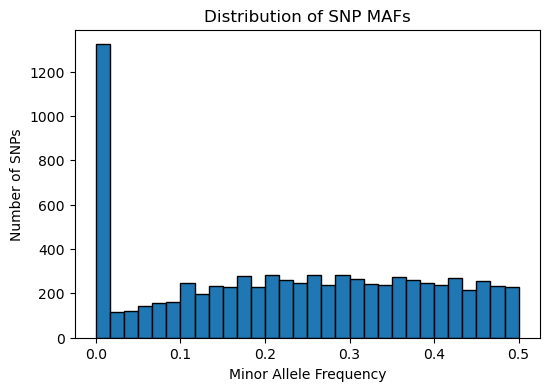

1559

In [52]:
# Convert GT to numeric
geno_numeric = vcf_filtered[sample_cols].map(gt_to_num)

# Allele frequency
allele_count = geno_numeric.sum(axis=1)
called = geno_numeric.notna().sum(axis=1)
allele_total = 2 * called
freq = allele_count / allele_total

# Minor allele frequency
maf = np.where(freq <= 0.5, freq, 1 - freq)

# Fix warnings by copying
vcf_filtered = vcf_filtered.copy()
vcf_filtered["MAF"] = maf

# Histogram
plt.figure(figsize=(6,4))
plt.hist(maf, bins=30, edgecolor="black")
plt.xlabel("Minor Allele Frequency")
plt.ylabel("Number of SNPs")
plt.title("Distribution of SNP MAFs")
plt.show()

# Filtering
vcf_maf_filtered = vcf_filtered[maf > 0.05]

num_removed_maf = len(vcf_filtered) - len(vcf_maf_filtered)
num_removed_maf
